From https://www.sciencedirect.com/science/article/pii/S030440762100227X#appSB

# Scalable Inference for stochastic volatility.
## Produce randomised datasets for the given model

In [1]:
import jax.random as jr
import jax.numpy as jnp
from jax import lax, jit, Array, vmap
import jax

from utils.datasets import Dataset

SEED = 10

### Diagnostic Functions

In [2]:
def is_psd_cholesky(A: jnp.ndarray) -> bool:
    try:
        _ = jnp.linalg.cholesky(A + 1e-10 * jnp.eye(A.shape[0]))
        return True
    except jax.errors.ConcretizationTypeError:
        # when tracing under jit, don't use Python exceptions
        raise
    except Exception:
        return False


### Helper Functions

In [9]:
def givens_rotation(D, i, j, omega):
    """
    Create an n x n Givens rotation matrix that rotates in the (i, j) plane.

    Parameters:
        D (int): Dimension of the square matrix.
        i (int): First index (0-based).
        j (int): Second index (0-based).
        omega (float): Rotation angle in radians.

    Returns:
        jnp.ndarray: Givens rotation matrix.
    """
    
    # Start with identity
    G = jnp.eye(D)
    c = jnp.cos(omega)
    s = jnp.sin(omega)

    # Apply rotation in (i, j) plane
    G = G.at[i, i].set(c)
    G = G.at[j, j].set(c)
    G = G.at[i, j].set(s)
    G = G.at[j, i].set(-s)

    return G


@jit
def givens_product(w_ij: Array):
    """
    w_ij: (D, D) angles; we use only strict upper-triangle (i<j).
    
    Returns:
        G_all: (M, D, D) stack of Givens in lexicographic (i,j) order
        R: (D, D) product G_{(0)} @ G_{(1)} @ ... @ G_{(M-1)}
    """
    
    D = w_ij.shape[0]
    i_idx, j_idx = jnp.triu_indices(D, k=1)          # vectors of length M
    omegas = w_ij[i_idx, j_idx]                       # (M,)

    # construct Givens matrices over all (i,j,omega)
    G_all = vmap(
        lambda ii, jj, om: givens_rotation(D, ii, jj, om),
        in_axes=(0, 0, 0)
    )(i_idx, j_idx, omegas)

    # multiply all Givens matrices
    P = lax.associative_scan(lambda A, B: B @ A, G_all)[-1]
    return P


def invert_transform(delta):
    """ Invert transform delta to (-pi/2, pi/2) for Givens rotation angle """
    
    return (jnp.pi / 2) * (jnp.exp(delta) - 1) / (jnp.exp(delta) + 1)

def inverse_gamma(key, alpha, beta, shape):
    return 1.0 / (jr.gamma(key, alpha, shape) / beta) 

In [38]:
def generate_stock_price_data(key: jr.PRNGKey, K: int, D: int, T: int):
    """
    Generate returns according to the model in scalable inference paper

    K: factor dimension
    D: returns dimension
    """

    assert D >= K, "Factor dimension cannot be greater than observation dimension"

    # randomly sample all necessary parameters 
    key, key_h = jr.split(key)
    h_i0 = jr.normal(key_h, shape=(K))

    key, key_d = jr.split(key)
    d_ij0 = jr.normal(key_d, shape=(K, K))
    d_ij0 = d_ij0.at[jnp.tril_indices(K)].set(0)

    key, key_lambda_h, key_mu_h, key_phi_h = jr.split(key, 4)
    lambda_h = jr.gamma(key_lambda_h, 1)
    mu_h = jr.normal(key_mu_h) * (1.0 / jnp.sqrt(lambda_h))
    phi_h_hat = mu_h + (jr.normal(key_phi_h, shape=(K)) * jnp.sqrt(1.0 / lambda_h))
    phi_h = (jnp.exp(phi_h_hat) - 1) / (jnp.exp(phi_h_hat) + 1)
    
    key, key_lambda_d, key_mu_d, key_phi_d = jr.split(key, 4)
    lambda_d = jr.gamma(key_lambda_d, 1)
    mu_d = jr.normal(key_mu_d) * (1.0 / jnp.sqrt(lambda_d))
    phi_d_hat = mu_d + (jr.normal(key_phi_d, shape=(K, K)) * jnp.sqrt(1.0 / lambda_d))
    phi_d = (jnp.exp(phi_d_hat) - 1) / (jnp.exp(phi_d_hat) + 1)

    key, key_sigma_h = jr.split(key)
    sigma_h = jnp.sqrt(inverse_gamma(key_sigma_h, 10, 0.1, (K)))

    key, key_sigma_d = jr.split(key)
    sigma_d = jnp.sqrt(inverse_gamma(key_sigma_d, 10, 0.1, (K, K)))
    
    key, key_h1 = jr.split(key)
    h_i1 = (jr.normal(key_h1, shape=(K)) + h_i0) * sigma_h / jnp.sqrt(1 - phi_h**2)

    key, key_d1 = jr.split(key)
    d_ij1 = (jr.normal(key_d1, shape=(K, K)) + d_ij0) * sigma_d / jnp.sqrt(1 - phi_d**2)
    
    key, key_B = jr.split(key)
    B = jr.normal(key_B, shape=(D, K)) if D != K else jnp.eye(D)

    key, key_V = jr.split(key)
    V = jnp.diag(jr.uniform(key_V, shape=(D))) if D != K else jnp.eye(D)

    # calculate factors and returns at t1 
    w_ij1 = invert_transform(d_ij1)  # (jnp.pi / 2) * (jnp.exp(d_ij1) - 1) / (jnp.exp(d_ij1) + 1)
    P1 = givens_product(w_ij1)
    L1 = jnp.diag(jnp.exp(h_i1))
    S1 = P1 @ L1 @ P1.T

    key, key_f, key_r = jr.split(key, 3)
    f1 = jr.multivariate_normal(key_f, jnp.zeros(K), S1)
    r1 = jr.multivariate_normal(key_r, B @ f1, V)

    # pre-generate noise for latent Gaussian processes
    key, key_eta_h, key_eta_d = jr.split(key, 3)
    eta_h = jr.normal(key_eta_h, shape=(T-1, K))
    eta_d = jr.normal(key_eta_d, shape=(T-1, K, K))

    # simulate latent dynamics
    mask_upper = jnp.triu(jnp.ones((K, K)), k=1)
    def step(carry, noise):
        
        h_it, d_ijt = carry   # other params are accessed from global scope
        eta_ht, eta_dt = noise
        
        h_i = h_i0 + phi_h * (h_it - h_i0) + sigma_h * eta_ht 
        d_ij = d_ij0 + phi_d * (d_ijt - d_ij0) + sigma_d * eta_dt
        d_ij = d_ij * mask_upper

        return (h_i, d_ij), (h_i, d_ij)
        
    carry0 = (h_i1, d_ij1)
    noise = (eta_h, eta_d)

    _, paths = lax.scan(step, carry0, noise)

    # back-calculate all rotation angles, factors and returns
    w_ij = vmap(lambda delta: invert_transform(delta))(paths[1])   # (T, K, K)
    P = vmap(lambda omega: givens_product(omega))(w_ij)            # (T, K, K)
    L = vmap(lambda h: jnp.diag(jnp.exp(h)))(paths[0])             # (T, K, K)
    S = vmap(lambda Pt, Lt: Pt @ Lt @ Pt.T)(P, L)

    keys = jr.split(key, 2*(T-1) + 1)
    f = vmap(lambda k, St: jr.multivariate_normal(k, jnp.zeros(K), St))(keys[:T-1], S)
    r = vmap(lambda k, ft: jr.multivariate_normal(k, B @ ft, V))(keys[T-1:-1], f)

    f = jnp.concatenate([f1[None, ...], f])
    r = jnp.concatenate([r1[None, ...], r])

    params = {
        "h0": h_i0,
        "d0": d_ij0,
        "phi_h": phi_h,
        "phi_d": phi_d,
        "sigma_h": sigma_h,
        "sigma_d": sigma_d,
        "B": B,
        "V": V
    }
    
    return Dataset(
        train_data=r,
        train_states=f,
        val_data=None,
        val_states=None,
        params=params
    )

In [39]:
ds = generate_stock_price_data(jr.PRNGKey(SEED), 5, 5, 100)

In [40]:
ds.params["V"]

Array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

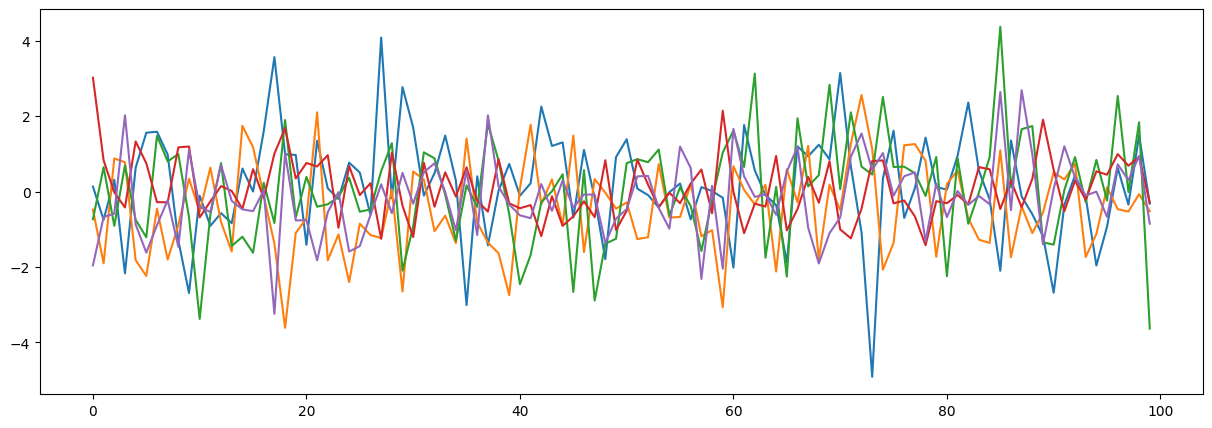

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(ds.train_states)
plt.show()